# FIN 342 Homework 2: Improving Charge-off Predictions

I have cleaned up the notebook so it only contains the things that are relevant to what i wanted to change. I hope that's okay.

## Import libraries and create dataframe from SQLite database
I only imported the columns that I am interested in. This increases the time to load the data. 

In [1]:
import sqlite3 #this library manages sql databases
import pandas as pd  #this library enables data manipulation and analysis methods to be used in Python
import numpy as np #this library focuses on scientific computing and using arrays and matrices
%matplotlib inline
import matplotlib.pyplot as plt #this imports the matplotlib library, along with the interactive plotting pylab module

conn = sqlite3.connect('database.sqlite') # This runs sql within Python; will take a few minutes to run - literally, a few minutes
#to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d'] #takes a look at the columns, and cuts them up along columns, extracts columns so we can build a Python dataframe
#df = pd.read_sql_query('select * from loan', con=conn, parse_dates = to_parse) #pandas feature, read SQL query into dataframe and load in-memory
df = pd.read_sql_query('select annual_inc, collections_12_mths_ex_med, delinq_2yrs, dti, earliest_cr_line, emp_length, emp_title, funded_amnt, funded_amnt_inv, grade, home_ownership, initial_list_status, inq_last_6mths, installment, verification_status, issue_d, loan_amnt, loan_status, mths_since_last_delinq, mths_since_last_major_derog, mths_since_last_record, open_acc, pub_rec, purpose, revol_bal, revol_util, sub_grade, term, total_acc, zip_code, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, total_rev_hi_lim, inq_fi, total_cu_tl, acc_now_delinq, tot_coll_amt, tot_cur_bal from loan', con=conn) #pandas feature, read SQL query into dataframe and load in-memory
pd.set_option('max_columns', 100) #Increase the head() functions columns.

## Data manipulation
Below i modify the data. Mostly, i use the same approach as in the original notebook. The variables that I added and needed modification are first. After the original variables' modifications are listed.

In [2]:
#NEW VARIABLES:
#New variable that proxies 'ability to pay':
df['inst_to_inc'] = df.installment / df.annual_inc

#New variable that measures utilization of revolving credit:
df['revol_util'] = df['revol_util'].str.split('%').str[0]
df['revol_util'] = df.revol_util.astype(float)/100
df['revol_util'] = df['revol_util'].fillna(df.revol_util.median())

#New variable that measures the current balance on borrowers' accounts:
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(df.tot_cur_bal.median())

#New variable that measures if borrower has current deliquencies:
df['acc_now_delinq_cat'] = 'no'
df.loc[df['acc_now_delinq']> 0,'acc_now_delinq_cat'] = 'yes'
    
    

#ORIGINAL VARIABLES:    
# amt_difference
df['amt_difference'] = 'eq' #set equal as the default value for amt_difference
df.loc[(df['funded_amnt'] - df['funded_amnt_inv']) > 0,'amt_difference'] = 'less'
# Turn some continuous variables into binaries
df['delinq_2yrs_cat'] = 'no'
df.loc[df['delinq_2yrs']> 0,'delinq_2yrs_cat'] = 'yes'
#.loc access a group of rows and columns by label(s) or a boolean/conditional lookup, which is why it is being used here
#label used is the dataframe for delinq, if greater than 0 assigning those values yes
#.loc lets us scour this data and insert yes when the boolean condition demands it

df['inq_last_6mths_cat'] = 'no'
df.loc[df['inq_last_6mths']> 0,'inq_last_6mths_cat'] = 'yes'
#same idea as above

df['pub_rec_cat'] = 'no'
df.loc[df['pub_rec']> 0,'pub_rec_cat'] = 'yes'
#same idea as above

# Create new metric: which fraction of total credit lines is the borrower currently able to still borrow from?
df['acc_ratio'] = df.open_acc / df.total_acc

#Modify emp_length
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length'] = df['emp_length'].fillna(0) #Assume n/a is students, thus set to zero to indicate their ability to pay is lower than employed people.

#Modify term
df['term'] = df['term'].str.split(' ').str[1] #str = string
df['term'] = df['term'].astype(float)

## Variables
I have added six new variables because I am afraid that the original number is too low. Problem: Overfitting. I will solve this later.

In [3]:
features = [
            #Original variables
            'loan_amnt', 'amt_difference', 'term',
            'installment', 'grade', 'emp_length', 
            'home_ownership', 'annual_inc', 'verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 
            #New variables:
            'tot_cur_bal', 'sub_grade', 'acc_now_delinq_cat', 
            'inst_to_inc', 'revol_bal', 'revol_util',
            #Original:
            'initial_list_status', 'loan_status']

The next part is not changed:

In [4]:
X_clean = df.loc[df.loan_status != 'Current', features] #features is at end to specify which columns we are specifically interested in looking through and using in X_clean dataframe
#the cleaned dataframe is one that has it where the loan status is not equal to current
#again, using loc as it lets us access rows and columns by label(s) or a boolean/conditional lookup
#X_clean.head() #get overview of new dataframe that is prepped for modelling

In [5]:
mask = (X_clean.loan_status == 'Charged Off')  # == is a python operator that checks if two values are equal to each other or not
#if they are, it returns True, and False if not
#this line creates a boolean condition, where mask = True if the loan status is 'Charged Off', and mask = false if not 
X_clean['target'] = 0
#this creates a new column called 'target', which stands for the target variable and end product we are trying to predict
#sets target to 0 for all values
X_clean.loc[mask,'target'] = 1
#this uses .loc method to access cleaned dataframe with mask and 'target arguments', meaning that if mask is true, to set target for that specific data point in the column equal to one
#this is important as this essentially gives us a clear way to point out which data points we are interested in
#as mask is reflecting which loan statuses are charged off or not, and helping to assign charged off points a value of 1 with the latest line of code
#X_clean.head()

No changes except that the new variables are encoded using one hot encoding if they are categorical:

In [6]:
cat_features = ['amt_difference','verification_status', 'home_ownership', 'grade','purpose', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat','acc_now_delinq_cat','sub_grade','initial_list_status']
#'sub_grade', 'grade', 'acc_now_delinq_cat', 'home_ownership', 'verification_status',
#make a list of the categorical variables we want to transform using one hot encoder

X_clean.dropna(axis=0, how = 'any', inplace = True)
# Drop any residual missing values, as this will tamper with one hot encoder

X = pd.get_dummies(X_clean[X_clean.columns[:-2]], columns=cat_features).astype(float) #setting x values #FIGURE OUT
#Convert categorical variable into dummy/indicator variables using get_dummies
#X_clean[X_clean.columns[:-2]] = specify the dataframe wwe are using, X_CLean, specify using all columns except the last two (initial_list_status and loan_status)
#Do you know why we are not including these two columns?
#Columns = cat_features specifies which columns in the DataFrame to be encoded. If columns is None then all the columns with object or category dtype will be converted.
#encode as type float
y = X_clean['target'] 
#assign the target values from dataframe to y

## Recap
The new variables that have been added are summarized in the table below. All this data is encompassed in 90 columns!!! Isse is overfitting, but lets run the model on this dataset first. 

In [7]:
X.head()

,loan_amnt,term,installment,emp_length,annual_inc,dti,open_acc,pub_rec,acc_ratio,tot_cur_bal,inst_to_inc,revol_bal,revol_util,amt_difference_eq,amt_difference_less,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,delinq_2yrs_cat_no,delinq_2yrs_cat_yes,inq_last_6mths_cat_no,inq_last_6mths_cat_yes,pub_rec_cat_no,pub_rec_cat_yes,acc_now_delinq_cat_no,acc_now_delinq_cat_yes,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,initial_list_status_f,initial_list_status_w
0,5000.0,36.0,162.87,10.0,24000.0,27.65,3.0,0.0,0.333333,80558.5,0.006786,13648.0,0.837,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,60.0,59.83,1.0,30000.0,1.00,3.0,0.0,0.750000,80558.5,0.001994,1687.0,0.094,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2400.0,36.0,84.33,10.0,12252.0,8.72,2.0,0.0,0.200000,80558.5,0.006883,2956.0,0.985,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10000.0,36.0,339.31,10.0,49200.0,20.00,10.0,0.0,0.270270,80558.5,0.006897,5598.0,0.210,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,5000.0,36.0,156.46,3.0,36000.0,11.20,9.0,0.0,0.750000,80558.5,0.004346,7963.0,0.283,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
len(X.columns)

90

In [9]:
from sklearn.linear_model import LogisticRegression #Imports logistic regression feature for analysis
from sklearn.feature_selection import RFE #Import R
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split #Imports train testing split, which split arrays or matrices into random train and test subsets
#chooses a random subset (a specified fraction) of X and y as a training sample, uses the remainder as a test sample. random_state sets the initial value.
from sklearn.model_selection import cross_val_score # Allows us to evaluate data by cross-validation
#Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: 
#a model that would just repeat the labels of the samples that it has just seen would have a perfect score but 
#would fail to predict anything useful on yet-unseen data. This situation is called overfitting. 
#To avoid it, it is common practice when performing a (supervised) machine learning experiment to 
#hold out part of the available data as a test set X_test, y_test. 
from sklearn import metrics #The sklearn.metrics module includes score functions, performance metrics 
#and pairwise metrics and distance computations.
from sklearn import preprocessing #The sklearn.preprocessing package provides several common utility 
#functions and transformer classes to change raw feature vectors into a representation that is more 
#suitable for the downstream estimators.
from sklearn.ensemble import RandomForestClassifier #import random forest classifier to use random forest
from imblearn.over_sampling import SMOTE #Import SMOTE feature, explained below

X_scaled = preprocessing.scale(X) #standardize data set along x axis and scale properly
#print(X_scaled)
#print('   ')
#print(X_scaled.shape) #dimensions

In [10]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'): #run_models is used below to run them
    #define the funciton run models, with the parameters:
    #X_train: training data set
    #Y_train: set of labels to all the data in x_train
    #The training set is a subset of the data set used to train a model.
    #X_test: test data set
    #y_test:  set of labels to all the data in x_test
    #model_type: specify the type of model we want to use
    #we select non-balanced for now, just to see how the initial model will fare
    
    clfs = {
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10) #n_estimators sets the number of trees in forest for model
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    #Establish which methods we want to use - Logistic Regression and Random Forest - with the clfs line that creates a dictionary
    #of the two
    #cols establishes a list of the specific columns of metrics we want
    
    models_report = pd.DataFrame(columns = cols) #this is used to generate an empty model report
    conf_matrix = dict() #create a dictionary for the confidence matrix that assigns the confidence values to specific keys

    for clf, clf_name in zip(clfs.values(), clfs.keys()): 
        #establish a for loop saying that for each method name and value,

        clf.fit(X_train, y_train)
        #Train the model by fitting it to data, using the training data set as inputs
        
        y_pred = clf.predict(X_test) #the predicted labels that will be returned from 
        #.predict, which predicts target values of X given a model
        y_score = clf.predict_proba(X_test)[:,1] #the Target scores, 
        #can either be probability estimates of the positive class, confidence values, 
        #or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
        #obtained using .predict_proba, which is a
        #method of a (soft) classifier outputting the probability of the instance being in each of the classes.
        
        print('computing {} - {} '.format(clf_name, model_type)) #print output saying that the file is computing
        #specific model, which is why.format is used at end to pull name and model type to plug into statement

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})
        #create a dictionary of series names and keys assigning values for what each item is
        #the keys are the desired items we want in the end for our model analysis, with the values
        #explaining how each key is assigned/calculated 
        
        models_report = models_report.append(tmp, ignore_index = True)
        #append the tmp values to our currently empty model report
        #ignore_index = True means we ignore and do not use the index labels, do this as the report needs to show
        #only the names, not the methods for how each item is analyzed
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        #establish the confidence matrix, crosstab Compute a simple cross-tabulation of two (or more) factors.
        #Cross tabulation is a tool that allows you compare the relationship between two or more factors.
        #Can you tell what factors are we cross tabulating?
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        #the returns of the ROC curve, all three are arrays 
        #hence use of metrics.roc_curve, uses y test data and target scores to determine three return values
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
        plt.plot([0,1],[0,1], color = 'black')
        #plotting dimensions and specifics for the result graph
    
    return models_report, conf_matrix
    #after running function, also give us models_report and confidence matrix for methods

computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 


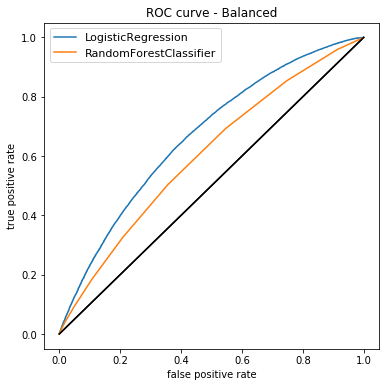

In [11]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.4, random_state=0)

#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [12]:
len(X.columns)

90

In [13]:
models_report_bal

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.171777,0.667522,0.208014,0.678525,0.318413,Balanced
1,RandomForestClassifier,0.084072,0.602034,0.224368,0.184875,0.202716,Balanced


In [14]:
conf_matrix_bal['LogisticRegression'] #balanced logistic regression

Predicted,0,1
True,,
0,69151,53086
1,6606,13943


In [15]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

Predicted,0,1
True,,
0,109104,13133
1,16750,3799


This result is not good since it is not significantly better than the original model. The problem is that we have too many non-predictive variables in the model. 

## Solving the problems with too many features
By using sklearn.feature_selection.RFE (Recursive Feature Elimination) we can rank the estimators based on their ability to predict default. This allows us to choose the most effective ones and discard the ones making our better. The code below outputs an array of True and False based on whether each of the 90 columns of estimators are among the 50 best (TRUE), or not (FALSE). What we want to do is remove the 40 worst estimators. The number of 50 estimators are chosen based on trial and error. 

In [16]:
from sklearn.feature_selection import RFE
logreg = LogisticRegression()
rfe = RFE(logreg, 50)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)

[ True  True  True False  True  True  True False  True  True  True  True
  True  True  True False False False False False False False  True False
  True  True  True  True  True  True False False  True False False False
 False False  True  True  True False  True False False False  True  True
  True False False  True  True  True  True  True  True False  True  True
  True False False False False  True  True  True  True  True  True  True
  True False False False False False False False False False False  True
  True  True False False  True  True]


We create a varibel that contains the indexes of FALSE. We will then use those indexies to remove the corresponding columns in the X-variable. 

In [17]:
delete_columns = np.where(rfe.support_==False)

In [18]:
print(len(X.columns)) #Current number of columns in X. Too many!

90


In [19]:
X.head() #Show the current X features.

,loan_amnt,term,installment,emp_length,annual_inc,dti,open_acc,pub_rec,acc_ratio,tot_cur_bal,inst_to_inc,revol_bal,revol_util,amt_difference_eq,amt_difference_less,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,delinq_2yrs_cat_no,delinq_2yrs_cat_yes,inq_last_6mths_cat_no,inq_last_6mths_cat_yes,pub_rec_cat_no,pub_rec_cat_yes,acc_now_delinq_cat_no,acc_now_delinq_cat_yes,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,initial_list_status_f,initial_list_status_w
0,5000.0,36.0,162.87,10.0,24000.0,27.65,3.0,0.0,0.333333,80558.5,0.006786,13648.0,0.837,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,60.0,59.83,1.0,30000.0,1.00,3.0,0.0,0.750000,80558.5,0.001994,1687.0,0.094,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2400.0,36.0,84.33,10.0,12252.0,8.72,2.0,0.0,0.200000,80558.5,0.006883,2956.0,0.985,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10000.0,36.0,339.31,10.0,49200.0,20.00,10.0,0.0,0.270270,80558.5,0.006897,5598.0,0.210,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,5000.0,36.0,156.46,3.0,36000.0,11.20,9.0,0.0,0.750000,80558.5,0.004346,7963.0,0.283,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


The following function drops the columns based on wheter RFE has determined that the estimator has low predictive power. The result is an X with only 50 columns with good prediction power. 

In [20]:
X.drop(X.columns[delete_columns],axis=1,inplace=True)

In [21]:
print(len(X.columns)) #New, smaller X

50


In [22]:
X.head() #Overview of X

,loan_amnt,term,installment,annual_inc,dti,open_acc,acc_ratio,tot_cur_bal,inst_to_inc,revol_bal,revol_util,amt_difference_eq,amt_difference_less,home_ownership_OWN,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,purpose_credit_card,purpose_medical,purpose_moving,purpose_other,purpose_small_business,delinq_2yrs_cat_yes,inq_last_6mths_cat_no,inq_last_6mths_cat_yes,acc_now_delinq_cat_no,acc_now_delinq_cat_yes,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_G1,sub_grade_G2,sub_grade_G3,initial_list_status_f,initial_list_status_w
0,5000.0,36.0,162.87,24000.0,27.65,3.0,0.333333,80558.5,0.006786,13648.0,0.837,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,60.0,59.83,30000.0,1.00,3.0,0.750000,80558.5,0.001994,1687.0,0.094,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2400.0,36.0,84.33,12252.0,8.72,2.0,0.200000,80558.5,0.006883,2956.0,0.985,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10000.0,36.0,339.31,49200.0,20.00,10.0,0.270270,80558.5,0.006897,5598.0,0.210,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,5000.0,36.0,156.46,36000.0,11.20,9.0,0.750000,80558.5,0.004346,7963.0,0.283,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Run the model again
Lets run the model again with the bad estimators removed.

In [23]:
X_scaled = preprocessing.scale(X) #standardize data set along x axis and scale properly

computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 


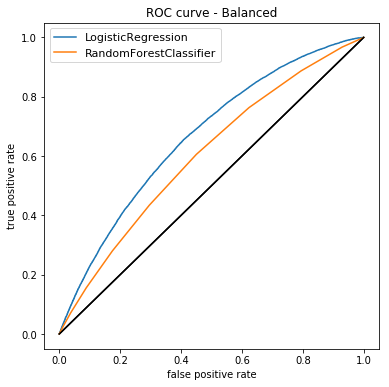

In [24]:
index_split = int(len(X)/2)#split index in by length of X/2
X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
#use SMOTE to fit sample
#Define X parameter to fit to and Y
#new training data set
X_test, y_test = X_scaled[index_split:], y[index_split:]
#define test data

#scores = cross_val_score(clf, X_scaled, y , cv=5, scoring='roc_auc')
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
#same as before, but change model type to balanced now
#The “balanced” mode uses the values of y to automatically adjust weights 
#inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

In [25]:
models_report_bal

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,LogisticRegression,0.169795,0.666577,0.205644,0.689377,0.316789,Balanced
1,RandomForestClassifier,0.094627,0.603860,0.212538,0.280306,0.241763,Balanced


In [26]:
conf_matrix_bal['LogisticRegression'] #balanced logistic regression

Predicted,0,1
True,,
0,67517,54720
1,6383,14166


In [27]:
conf_matrix_bal['RandomForestClassifier'] #balanced logistic regression

Predicted,0,1
True,,
0,100896,21341
1,14789,5760


## Conclusion
### Logistic Regression
This result is better than the original model. The logistic regression is about 4% better measured on Matthews correlation coefficient (MCC), but only 1% better measured on ROC_AUC. Precision score is a little higher, but recall is also worse. F1 score is about 2% better.
### Random Forrest Classifier
This classification model fares much better relatively. All the scores are better than the original model except for precision, which means that we are able to predict default much better with this method.